In [3]:
# install sentence-transformer with pip
%pip install -U sentence-transformers
# !pip install cufflinks --upgrade

     |████████████████████████████████| 64 kB 629 kB/s  eta 0:00:01
     |████████████████████████████████| 1.2 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 776.8 MB 7.2 kB/s  eta 0:00:01     |███████████▊                    | 283.5 MB 68.3 MB/s eta 0:00:08
     |████████████████████████████████| 1.8 MB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 723 kB 55.5 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 57.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 33.6 MB/s eta 0:00:01
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-py3-none-any.whl size=103066 sha256=d2d665e9a85180428587f410b5f742723e1b82837900e7b660b21e72abc0a641
  Stored in directory: /home/ec2-user/.cache/pip/wheels/55/89/bd/ba279427485afb4c3a82327faa6e5b01973f8971112c248690
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=9b7bc716dc99d05e3122f97443c0b2cc55c6d8d6780b1716bd50

In [4]:
# import needed libraries
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
import pandas as pd 
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
#Plotly Tools
from plotly.offline import init_notebook_mode, iplot
import torch
import sys
import os
path = os.getcwd()
print(path)
print("Python version")
print (sys.version)
print("PyTorch version")
print(torch.__version__)

/home/ec2-user/SageMaker/hank
Python version
3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
PyTorch version
1.7.1


In [5]:
# load the train and test set
df_q_d = pd.read_csv("train_dataset.csv", error_bad_lines=False, engine="python")
df_test = pd.read_csv("test_dataset.csv", error_bad_lines=False, engine="python")

In [165]:
# data balance
print('number of unique document:',df_q_d.document.nunique())
df_q_d['label'].value_counts()

number of unique document: 10332


0    31114
1    11892
Name: label, dtype: int64

## Data Preprocessing

In [7]:
def preprocess(text):
    """
    clean text column
    """
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')
    """
    Remove URLs from a sample string
    """
    text = text.str.replace(r"\(http\S+\)", " <url>")
    text = text.str.replace(r"\(www\S+\)", " <url>")
        
    return text

In [8]:
def clean_text(sample):
    """Remove URLs from a sample string"""
    sample = re.sub(r"\(http\S+\)", " <url>", sample)
    sample = re.sub(r"\(www\S+\)", " <url>", sample)
    
    """Remove \n from a sample string"""
    sample = re.sub(r'\n', ' ', sample)
    
    """Lower case"""
    sample = sample.lower()

    return sample

In [9]:
df_q_d['query_cln'] = df_q_d['query'].apply(lambda x: clean_text(x))
df_q_d['document_cln'] = df_q_d['document'].apply(lambda x: clean_text(x))
df_test['query_cln'] = df_test['query'].apply(lambda x: clean_text(x))

In [10]:
# create new feature for the length of the query & document 
df_q_d['query_len'] = df_q_d['query'].astype(str).apply(len)
df_q_d['document_len'] = df_q_d['document'].astype(str).apply(len)
# create new feature for the word count of the query & document
df_q_d['query_word_count'] = df_q_d['query'].apply(lambda x: len(str(x).split()))
df_q_d['document_word_count'] = df_q_d['document'].apply(lambda x: len(str(x).split()))

In [164]:
df_q_d.head(5)

,query,document,label,query_cln,document_cln,query_len,document_len,query_word_count,document_word_count,amazon_related,amazon_related_doc
0,Cancel digital order I didn’t order.,Cancel an Accidental Purchase: You are able to...,0,cancel digital order i didn’t order.,cancel an accidental purchase: you are able to...,36,1434,6,161,0,1
1,NEED TO KNOW THE STATUS OF RETURNED ITEM,Verify Continuing Student Status: If you're a ...,0,need to know the status of returned item,verify continuing student status: if you're a ...,40,1449,8,210,1,1
2,I received a gift off my registry and it was s...,Returning Gifts from Your Baby Registry: The e...,0,i received a gift off my registry and it was s...,returning gifts from your baby registry: the e...,139,1080,29,146,1,1
3,How do I get internet on Amazon Fire?,Connect Your Fire Tablet to Wi-Fi\n\nAccess Wi...,1,how do i get internet on amazon fire?,connect your fire tablet to wi-fi access wi-f...,37,325,8,55,1,1
4,I received an email saying my account info has...,Protect Your System: Some suspicious emails co...,0,i received an email saying my account info has...,protect your system: some suspicious emails co...,68,2752,12,408,1,1


In [38]:
# Very clear distinction between amazon and non-amazon questions 
# using a few search terms, we were able to distinguish between amazon & non-amazon documents
question_searchfor = ['Amazon','amazon', 'kindle', 'fire stick',
'refund', 'gift', 'subscription', 'password',
'Kindle', 'shipping','channels','email','Alexa','Fire TV','item',
'membership','book','delivery','payment', 'reviews', 'promo', 'seller', 'REFUND'
'package', 'replace', 'credit card', 'review', 'prime', 'package', 'showtime',
'Shipping', 'coupon', 'registry', 'Whole Foods', 'Replacement', 'PAYMENT', 'Prime',
'charge', 'REFUND', 'AMAZON', 'renewal', 'Package',
'Refund', 'delivered', 'account', 'credit', 'Email','•']
            
# create labels for amazon or non-amazon queries and documents
df_q_d['amazon_related'] = np.where(df_q_d['query_cln'].str.contains('|'.join(question_searchfor)), 1, 0)
df_test['amazon_related'] = np.where(df_test['query_cln'].str.contains('|'.join(question_searchfor)), 1, 0)
 
df_q_d['amazon_related_doc'] = np.where(df_q_d['document_cln'].str.contains('|'.join(question_searchfor)), 1, 0)

In [167]:
# there are about 29872 amazon related questions (~69%) & 
# 13134 non-amazon related questions (~31%) in training set
df_q_d.groupby(by= 'amazon_related').size()

amazon_related
0    13134
1    29872
dtype: int64

In [172]:
# proportion of amazon/ non-amazon in test 
# In test set, there are about 1364 amazon related questions (~55%) & 
# 1115 non-amazon related questions (~45%) 
df_test.groupby(by= 'amazon_related').size()

amazon_related
0    1115
1    1364
dtype: int64

In [171]:
# there are about 2214 Amazon Related Document
# 8835 Non-Amazon Related Documents 
df_q_d.groupby(by='amazon_related_doc').nunique()

,query,document,label,query_cln,document_cln,query_len,document_len,query_word_count,document_word_count,amazon_related,amazon_related_doc
amazon_related_doc,,,,,,,,,,,
0,2176,8118,2,2176,8118,80,736,18,163,2,1
1,9389,2214,2,9389,2214,178,1065,40,336,2,1


In [41]:
# check missing value for each field
df_q_d.isnull().sum()

query                  0
document               0
label                  0
query_cln              0
document_cln           0
query_len              0
document_len           0
query_word_count       0
document_word_count    0
amazon_related         0
amazon_related_doc     0
dtype: int64

Summary:
1. In the training set, there are roughly **29,872** amazon related questions: ~69% & 13134 non-amazon related questions ~31% in training set
2. Furthermore, there are **11,000** unique questions in the training set. Most questions are asked 4 times: ~70% of unqiue questions or only one time: ~15% of unique questions)
3. Proportion of amazon/non-amazon in test
  * ~60%% amazon/ 40% non-amazon in test
4. Proportion of amazon questions that have an answer in dataset (can check based on the unque question) 
  * all questions have an answer

In [42]:
# two list of sentences for amazon related questions
training_question = df_q_d.loc[(df_q_d['amazon_related'] == 1) & (df_q_d['label'] == 1)]['query_cln'].unique().tolist()
testing_question = df_test.loc[df_test['amazon_related'] == 1]['query_cln'].unique().tolist()

In [43]:
# two list of sentences for non-amazon questions
training_question_non_amazon = df_q_d.loc[(df_q_d['amazon_related'] == 0) & (df_q_d['label'] == 1)]['query_cln'].unique().tolist()
testing_question_non_amazon = df_test.loc[df_test['amazon_related'] == 0]['query_cln'].unique().tolist()

In [44]:
# there are roughly 8057 unique questions that are amazon related in the training dataset question while 
# 1364 in testing set 
print(len(training_question))
print(len(testing_question))

8057
1364


## EDA

### The distribution of question length and word counts

count    43006.000000
mean        51.567107
std         29.435044
min          9.000000
25%         32.000000
50%         43.000000
75%         63.000000
max        187.000000
Name: query_len, dtype: float64


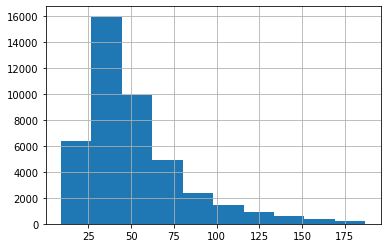

In [15]:
q_lens = df_q_d['query_len']
print(q_lens.describe())
q_lens.hist()

count    43006.000000
mean        10.252848
std          6.251205
min          2.000000
25%          6.000000
50%          9.000000
75%         13.000000
max         41.000000
Name: query_word_count, dtype: float64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aa600f8d0>,
      dtype=object)

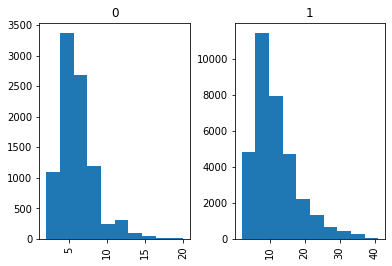

In [96]:
q_word_count = df_q_d['query_word_count']
print(q_word_count.describe())
df_q_d.hist(column='query_word_count', by='amazon_related')

### The distribution of document length and word count

count    43006.000000
mean      1189.230479
std        705.883182
min         38.000000
25%        539.000000
50%       1133.000000
75%       1704.000000
max       3965.000000
Name: document_len, dtype: float64


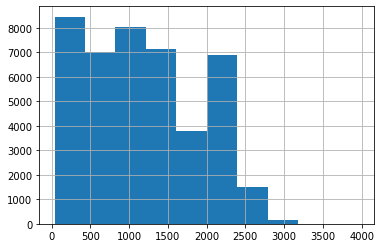

In [17]:
d_lens = df_q_d['document_len']
print(d_lens.describe())
d_lens.hist()

count    43006.000000
mean       177.471213
std        104.825797
min          6.000000
25%         89.000000
50%        162.000000
75%        250.000000
max        658.000000
Name: document_word_count, dtype: float64


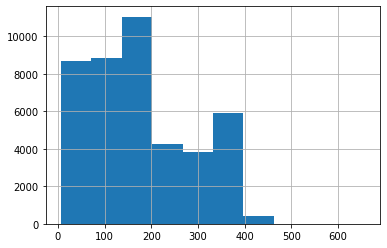

In [18]:
d_word_count = df_q_d['document_word_count']
print(d_word_count.describe())
d_word_count.hist()

In [183]:
df_q_d.head(2)

,query,document,label,qeury_cln,document_cln,query_len,document_len,query_word_count,document_word_count,query_cln,amazon_related
0,Cancel digital order I didn’t order.,Cancel an Accidental Purchase: You are able to...,0,cancel digital order i didn’t order.,cancel an accidental purchase: you are able to...,36,1434,6,161,cancel digital order i didn’t order.,1
1,NEED TO KNOW THE STATUS OF RETURNED ITEM,Verify Continuing Student Status: If you're a ...,0,need to know the status of returned item,verify continuing student status: if you're a ...,40,1449,8,210,need to know the status of returned item,1


## Load Sentence-Transformer Pre-Trained Model

In [ ]:
# getting SSL error in downloading model embeddings 
# https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/
# download the models if there is an error loading model from SentenceTransformer
! wget --no-check-certificate https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/distilbert-base-nli-stsb-quora-ranking.zip
# !unzip /content/bert-large-nli-stsb-mean-tokens.zip -d /root/.cache/torch/sentence_transformers/sbert.net_models_bert-large-nli-stsb-mean-tokens
!unzip /home/ec2-user/SageMaker/hank/distilbert-base-nli-stsb-quora-ranking.zip -d /home/ec2-user/SageMaker/hank/sbert.net_models_distilbert-base-nli-stsb-quora-ranking


In [24]:
pretrained_model = 'paraphrase-distilroberta-base-v1'
# download pretrained model, pretrained models can be loaded by just passing the model name 
# model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking')
model = SentenceTransformer('/home/ec2-user/SageMaker/hank/sbert.net_models_{0}'.format(pretrained_model))
# model = SentenceTransformer('quora-distilbert-base')

In [20]:
# drop duplicate question in the list
sentences= list(set(training_question) | set(testing_question))
sentences_non_amazon= list(set(training_question_non_amazon) | set(testing_question_non_amazon))

In [21]:
print(len(sentences))
print(len(sentences_non_amazon))

9195
4284


In [22]:
testing_question[0:20]

['what does safe mode on kindle fire mean for amazon?',
 'how do you cancel a gift card reload on amazon?',
 'i never received my refund voucher',
 'information about fraudulent charges using one of my companies credit cards',
 'hello i have someone sending me a gift and wanted to know about',
 'does amazon need my phone number?',
 'what is amazon authentication?',
 'i have a charge on my bank account i need help identifying',
 'cancel amazon music free trial',
 'a charge not made by me',
 'how do i add contacts to my alexa app for amazon?',
 'how do i set parental controls on firestick for amazon?',
 'a charge on my credit card by amazon that i do not recognize',
 'how to delete credit card for amazon?',
 'charges on my credit card from amazon that i did not make',
 'what is amazon prime video pin?',
 'i have an unauthorized charge on my card.',
 'can i change the delivery time for my whole foods delivery order?',
 'i would like a refund on my order it has never arrived and tracking s

## Semantic Textual Similarity - Useless took too much time to train

Once we have sentence embeddings computed, we want to compare them to each other. Below is how we can compute the cosine similarity between embeddings, for example, to measure the semantic similarity of two texts.

In [135]:
%%time
# compute embedding for both list 
embeddings1 = model.encode(training_question, convert_to_tensor=True)
embeddings2 = model.encode(testing_question, convert_to_tensor=True)

CPU times: user 21.3 s, sys: 6.62 s, total: 27.9 s
Wall time: 26.8 s


In [136]:
%%time
# compute cosine similarity 
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

CPU times: user 883 ms, sys: 120 ms, total: 1 s
Wall time: 503 ms


In [139]:
#Output the pairs with their score
for i in range(len(testing_question)):
    print("{} \t\t {} \n Score: {:.4f}".format(testing_question[i], training_question[i], cosine_scores[i][i]))

definition of a compound 		 Cancel digital order I didn’t order. 
 Score: -0.0305
What does safe mode on Kindle Fire mean for amazon? 		 NEED TO KNOW THE STATUS OF RETURNED ITEM 
 Score: 0.0490
How do you cancel a gift card reload on Amazon? 		 I received a gift off my registry and it was shattered when I opened the box. When I try to return or exchange, it says it isn't an option? 
 Score: 0.4701
who is the santa clara county supervisor for sunnyvale ca 		 How do I get internet on Amazon Fire? 
 Score: 0.0145
caffeine effects on heart 		 I received an email saying my account info has changed. What changed 
 Score: 0.0362
i never received my refund voucher 		 Why was my most recent order canceled? 
 Score: 0.2742
Information about fraudulent charges using one of my companies credit cards 		 Im trying to locate my package 
 Score: 0.2439
Hello I have someone sending me a gift and wanted to know about 		 I never received the first order, thats why i ordered a replacement 
 Score: 0.2506


In [77]:
%%time
# find the pairs with the highest cosine similarity scores 
# Single list of sentences
# sentences = testing_question + training_question

#Compute embeddings
embeddings = model.encode(sentences, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

for pair in pairs[0:10]:
    i, j = pair['index']
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))

KeyboardInterrupt: 

In [146]:
cosine_scores[1][2]

tensor(0.0686)

In [12]:
# provide sentences to the model and generate a list of numpy arrays with embeddings 
corpus_embeddings = model.encode(q_corpus)

## Paraphrase Mining - Feed the full set of questions as input to the model
paraphrase mining is the task of finding pharaphrases in a large corpus of sentences.
The approach presented there used a brute-force approach to score and rank all pairs.
In Semantic Textual Similarity we saw a simplified version of finding paraphrases in a list of sentences. The approach presented there used a brute-force approach to score and rank all pairs.
The downside of STS is that it fails to scale to large (10,000 and more) collections of sentences.
For larger collections, util offers the paraphrase_mining function that can be used to reduce computing time.

In [25]:
%%time
# amazon related questions sentences similarity 
paraphrases = util.paraphrase_mining(model, sentences, corpus_chunk_size=len(sentences), top_k=1)
data = []
for paraphrase in paraphrases:
    score, i, j = paraphrase
    data.append({'anchor': sentences[i], 'related': sentences[j], 'score': score})
#     print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], score))

CPU times: user 15.9 s, sys: 3.74 s, total: 19.7 s
Wall time: 17.6 s


In [29]:
df_result = pd.DataFrame(data)
# df_result_non_amazon = pd.DataFrame(data_non_amazon)

In [31]:
print(len(df_result))

7567


In [32]:
df_result.loc[(df_result.score < 0.7) & (df_result.score > 0.5)]

,anchor,related,score
6781,i have been receiving packages that i have not...,"hi, i received a package that i didn't order a...",0.699874
6782,trying to place an order. both items are eligi...,an order i want to place says there is a shipp...,0.699855
6783,can you have 2 amazon echos in different houses?,can you use 2 alexas in the same house for ama...,0.699790
6784,verifying refund amount,item refund amount,0.699732
6785,i would like to cancel showtime and cbs all ac...,i would like to cancel my showtime,0.699695
...,...,...,...
7535,unable to add a magazine bought elsewhere to m...,update address for magazine subscription,0.508280
7536,average deck replacement cost,an item replacement,0.507355
7537,please remove special offers from my kindle pa...,how do you highlight on kindle paperwhite for ...,0.504303
7538,i can’t access my account and they haven’t con...,hello i was just trying to cancel my business ...,0.501915


In [131]:
# Since we train the model on the entire question pool, we need to create lables for identify 
# if anchor or related questions are in testing pool
df_result['anchor_test'] = np.where(df_result['anchor'].isin(testing_question), 1, 0)
df_result['related_test'] = np.where(df_result['related'].isin(testing_question), 1, 0)
df_result['anchor_train'] = np.where(df_result['anchor'].isin(training_question), 1, 0)
df_result['related_train'] = np.where(df_result['related'].isin(training_question), 1, 0)

In [221]:
# non-amazon related
df_result_non_amazon['anchor_test'] = np.where(df_result_non_amazon['anchor'].isin(testing_question_non_amazon), 1, 0)
df_result_non_amazon['related_test'] = np.where(df_result_non_amazon['related'].isin(testing_question_non_amazon), 1, 0)
df_result_non_amazon['anchor_train'] = np.where(df_result_non_amazon['anchor'].isin(training_question_non_amazon), 1, 0)
df_result_non_amazon['related_train'] = np.where(df_result_non_amazon['related'].isin(training_question_non_amazon), 1, 0)

In [144]:
df_result_related = df_result.loc[(df_result['anchor_test'] == 1) & (df_result['related_train'] == 1) | 
              (df_result['anchor_train'] == 1) & (df_result['related_test'] == 1) ]

In [182]:
df_result_related.head(5)

,anchor,related,score,anchor_test,related_test,anchor_train,related_train
4,i returned an item but have not received a refund,i returned an item but have not received refund,0.991529,0,1,1,0
5,how do i delete an idea list for amazon?,how do i delete an idea list on amazon?,0.991468,1,0,0,1
6,can shipping and billing address be different ...,can billing and shipping address be different ...,0.990848,0,1,1,0
9,how do you follow someone on amazon?,how do i follow someone on amazon?,0.990470,0,1,1,0
10,i returned an item but haven't received my refund,i returned an item and haven't received my refund,0.990435,0,1,1,0


In [195]:
# condition 1: anchor is in test set with related question in training set 
# determine the threshold for cos-sim score 
test_1 = df_result.loc[(df_result['anchor_test'] == 1) & 
                       (df_result['related_train'] == 1) & 
                       (df_result['score'] > 0.53)]['anchor'].unique().tolist()

# condition 2: anchor is in training set with relevant question in test set 
test_2 = df_result.loc[(df_result['anchor_train'] == 1) & 
                       (df_result['related_test'] == 1) &
                       (df_result['score'] > 0.53)]['related'].unique().tolist()

In [223]:
# condition 1: anchor is in test set with related question in training set for non-amazon question
# determine the threshold for cos-sim score 
test_1_non_amazon = df_result_non_amazon.loc[(df_result_non_amazon['anchor_test'] == 1) & 
                       (df_result_non_amazon['related_train'] == 1) & 
                       (df_result_non_amazon['score'] > 0.53)]['anchor'].unique().tolist()

# condition 2: anchor is in training set with relevant question in test set 
test_2_non_amazon = df_result_non_amazon.loc[(df_result_non_amazon['anchor_train'] == 1) & 
                       (df_result_non_amazon['related_test'] == 1) &
                       (df_result_non_amazon['score'] > 0.53)]['related'].unique().tolist()

In [226]:
# for index 1 anchor question is in test set while related question is in training set
df_result_non_amazon.head(5)

,anchor,related,score,anchor_test,related_test,anchor_train,related_train
0,what is coarse crackles,what are coarse crackles,0.981338,0,0,1,1
1,what process divides a cell's cytoplasm,what process divides a cell cytoplasm,0.974407,1,0,0,1
2,how old is jace norman,how old is jace norman in,0.959834,1,0,0,1
3,can i get a number for customer service please,can i get a number to customer service,0.952537,0,0,1,1
4,what is involved in the socratic method?,what is the socratic method?,0.949446,0,1,1,0


In [197]:
# deduplicate the questions in two list 
test_final = list(set(test_1) | set(test_2))

In [224]:
test_final_non_amazon = list(set(test_1_non_amazon) | set(test_2_non_amazon))

In [198]:
test_final[2:5]

['can you get emails on amazon fire tablet?',
 'does billing address show on package for amazon?',
 'why am i being charged shipping for amazon?']

In [229]:
# combine with the rule-base approach to see if that performs better
df_test['label'] = np.where((df_test['query_cln'].isin(test_final)) | 
                            (df_test['query_cln'].str.contains('|'.join(question_searchfor))) |
                            (df_test['query_cln'].isin(test_final_non_amazon)), 
                            1,0)

## Semantic Search - Query to Query Sentence Similarity 
Train on different corpus of questions 

In [33]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from sentence_transformers import SentenceTransformer
import scipy.spatial

In [35]:
# There are many pre-trained models avaiable ready to use to generate embeddings 
pretrained_model = 'bert-large-nli-stsb-mean-tokens'
# download pretrained model, pretrained models can be loaded by just passing the model name 
# model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking')
embedder = SentenceTransformer('/home/ec2-user/SageMaker/hank/sbert.net_models_{0}'.format(pretrained_model))
# model = SentenceTransformer('quora-distilbert-base')

In [45]:
testing_question[2:10]

['i never received my refund voucher',
 'information about fraudulent charges using one of my companies credit cards',
 'hello i have someone sending me a gift and wanted to know about',
 'does amazon need my phone number?',
 'what is amazon authentication?',
 'i have a charge on my bank account i need help identifying',
 'cancel amazon music free trial',
 'a charge not made by me']

In [46]:
%%time
# generate questions embeddings 
corpus_embeddings = embedder.encode(training_question)
query_embeddings = embedder.encode(testing_question)

CPU times: user 1min 2s, sys: 19.5 s, total: 1min 22s
Wall time: 1min 21s


In [47]:
# ensure two vectors have the same dimensions 
print(corpus_embeddings.shape)
print(query_embeddings.shape)

(8057, 1024)
(1364, 1024)


In [49]:
%%time
closest_n = 1
data_semantic_search = []
for query, query_embedding in zip(testing_question, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 3 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        data_semantic_search.append({'anchor': query, 'related': training_question[idx], 'score': (1-distance)})
#         print(training_question_sample[idx].strip(), "(Score: %.4f)" % (1-distance))

CPU times: user 48.4 s, sys: 27.8 s, total: 1min 16s
Wall time: 1min 16s


In [50]:
df_ss = pd.DataFrame(data_semantic_search)

In [51]:
print(df_ss[['anchor', 'related']].iloc[23])
df_ss[(df_ss.score > 0.7) & (df_ss.score < 0.8)]

anchor     a package came to our address that we didn't o...
related    an item i ordered was missing in the package w...
Name: 23, dtype: object


,anchor,related,score
21,"i would like to know, if i send someone a gift...",i received an item i did not order it did not ...,0.701773
23,a package came to our address that we didn't o...,an item i ordered was missing in the package w...,0.732762
36,"i've been charged twice for prime ,i didn't us...",i have been charged twice for prime this month...,0.796961
41,why isnt an item i purchased returnable?,why is the item i purchased is stating it’s no...,0.781884
47,a registry item that has not arrived,i returned an item but it isn’t showing returned,0.712490
...,...,...,...
1322,i have a question about an item i received and...,i'd like to return an item but it said i can't...,0.776725
1336,why hasn’t my package been shipped,my package was not delivered,0.781976
1343,trying to figure out why my prime membership i...,"a charge on my credit card, $2• to find out wh...",0.733857
1361,unable to purchase items on my account. gettin...,charge on my credit card and i can't find it i...,0.766048


In [157]:
# result of amazon-related question to questions 
df_ss_a_list = df_ss[df_ss.score > 0.5]['anchor'].tolist()

In [52]:
df_ss.to_csv('test_train_pair.csv', header=True, encoding='utf-8' , index=False)

## Semantic Search - Query to Query for non-amazon question 
doesn't perform well

In [87]:
# generate questions embedding
corpus_embeddings_non_amazon = embedder.encode(training_question_non_amazon)
query_embeddings_non_amazon = embedder.encode(testing_question_non_amazon)

In [89]:
# ensure two vectors have the same dimensions 
print(corpus_embeddings_non_amazon.shape)
print(query_embeddings_non_amazon.shape)

(2943, 1024)
(1115, 1024)


In [88]:
%%time
closest_n = 1
data_semantic_search_non_amazon = []
for query, query_embedding in zip(testing_question_non_amazon, query_embeddings_non_amazon):
    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings_non_amazon, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 3 most similar sentences in corpus:")
    for idx, distance in results[0:closest_n]:
        data_semantic_search_non_amazon.append({'anchor': query, 'related': training_question_non_amazon[idx], 'score': (1-distance)})
#         print(training_question_sample[idx].strip(), "(Score: %.4f)" % (1-distance))

CPU times: user 15.9 s, sys: 0 ns, total: 15.9 s
Wall time: 15.9 s


In [93]:
df_ss_non_amazon = pd.DataFrame(data_semantic_search_non_amazon)

In [94]:
df_ss_non_amazon.to_csv('test_train_pair_non_amazon.csv', header=True, encoding='utf-8' , index=False)

In [149]:
df_ss_non_a_list = df_ss_non_amazon[df_ss_non_amazon.score > 0.7]['anchor'].tolist()

## Semantic Similarity: Question to Documents for non-Amazon questions (split)
split out the original document pool into sentences/ paragraphs

In [68]:
# Convert the corpus into a list of sentence
newlist = [line for paragraph in doc_list for line in paragraph.split('.')]
# drop duplicated sentence in doc pool 
newlist = list(set(newlist))

In [69]:
# len(newlist): 61946
len(newlist)

15472

In [70]:
%%time
# 10min 19s
document_embeddings = embedder.encode(newlist)

CPU times: user 2min 46s, sys: 57.3 s, total: 3min 43s
Wall time: 3min 41s


In [71]:
document_embeddings.shape

(15472, 1024)

In [72]:
# encode non amazon question
query_embeddings = embedder.encode(testing_question_non_amazon)

In [73]:
query_embeddings.shape

(1115, 1024)

In [76]:
%%time
# For each search term return 3 closest sentences: 6min 57s
# For each query return 1 closest sentence: 5min 10s
closest_n = 1
data_doc_search_split = []
for query, query_embedding in zip(testing_question_non_amazon, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], document_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        data_doc_search_split.append({'anchor': query, 'related': newlist[idx], 'score': (1-distance)})
#         print(newlist[idx].strip(), "(Score: %.4f)" % (1-distance))

CPU times: user 1min 14s, sys: 44.8 s, total: 1min 58s
Wall time: 1min 58s


In [77]:
df_doc_corpus_split = pd.DataFrame(data_doc_search_split)

In [78]:
df_doc_corpus_split.to_csv('test_doc_pair_split.csv', header=True, encoding='utf-8' , index=False)

In [160]:
# result of amazon-related question to questions 
df_doc_corpus_split_list = df_doc_corpus_split[df_doc_corpus_split.score > 0.68]['anchor'].tolist()

## Semantic Similarity: Question to Documents for non-Amazon questions (no split)
seems not perform well

In [174]:
# unique amazon-related document list
doc_list = df_q_d.loc[ (df_q_d['amazon_related_doc'] == 1)]['document_cln'].unique().tolist()

In [175]:
len(doc_list)

2214

In [79]:
# generate document emdeddings 
document_embeddings_non_split = embedder.encode(doc_list)

In [83]:
%%time
# For each search term return 3 closest sentences: 6min 57s
# For each query return 1 closest sentence: 5min 10s
closest_n = 1
data_doc_search = []
for query, query_embedding in zip(testing_question_non_amazon, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], document_embeddings_non_split, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        data_doc_search.append({'anchor': query, 'related': doc_list[idx], 'score': (1-distance)})
#         print(newlist[idx].strip(), "(Score: %.4f)" % (1-distance))

CPU times: user 9.61 s, sys: 0 ns, total: 9.61 s
Wall time: 9.61 s


In [84]:
df_doc_corpus = pd.DataFrame(data_doc_search)

In [85]:
df_doc_corpus.to_csv('test_doc_pair.csv', header=True, encoding='utf-8' , index=False)

In [86]:
df_q_d.groupby(by=['label', 'amazon_related']).size()

label  amazon_related
0      0                 10039
       1                 21075
1      0                  3095
       1                  8797
dtype: int64

In [409]:
df_doc_corpus[(df_doc_corpus.score < 0.7) & (df_doc_corpus.score > 0.65) ]

,anchor,related,score
1,who is the santa clara county supervisor for s...,santa clara county assessor's office 70 west h...,0.655050
5,restore nashua hours,hours of operation,0.672343
14,what is yt,y,0.691140
19,who sings whistle while you work in snow white,whistle while you work,0.658751
22,what is deductible on metlife dental,cost of dental crown,0.685674
...,...,...,...
953,how can organizations manage diversity effecti...,managing diversity and inclusion in organizati...,0.688632
957,how do i clear browsing data on my fire tablet?,clear app cache and data on your fire tablet (...,0.698319
963,what is the zip code for altamonte springs fl,"palm coast is located in flagler county, fl",0.677251
966,define compound complex sentences,"suffix, or to other root words to make a comp...",0.664969


In [128]:
# determine the threshold for this setting 
df_doc_corpus_list = df_doc_corpus[df_doc_corpus.score > 0.7]['anchor'].tolist()

In [533]:
df_doc_corpus.to_csv('test_doc_pair_non_amazon.csv', header=True, encoding='utf-8' , index=False)

### Best Combination of Different Approaches

In [161]:
# the best combination so far 
df_test['label'] = np.where((df_test['query_cln'].isin(df_ss_a_list)) | # query to query for amazon questions 
                            (df_test['query_cln'].str.contains('|'.join(question_searchfor))) | # rule-base
                            (df_test['query_cln'].isin(df_ss_non_a_list)) | # query to query for non amazon questions
                            (df_test['query_cln'].isin(df_doc_corpus_split_list)) # non amazon question with doc pool (split) 
                            ,1,0)


In [162]:
# check how many of them
df_test.groupby(by='label').size()

label
0     757
1    1722
dtype: int64

In [163]:
# write to a text file 
df_test.to_csv("submission14.txt", columns= ['ID', 'label'], header=True, index=None, sep=',', mode='w')

In [493]:
df_doc_corpus_p['anchor'][index_num]

'what gas does a battery give off'

In [494]:
df_doc_corpus_p_list = df_doc_corpus_p[df_doc_corpus_p.score > 0.6]['anchor'].tolist()

In [518]:
df_test['label'] = np.where((df_test['query_cln'].isin(df_ss_a_list)) | # amazon questions
                            (df_test['query_cln'].str.contains('|'.join(question_searchfor))) | # rule-base
                            # (df_test['query_cln'].isin(test_final_non_amazon)) | # non amazon question
                            (df_test['query_cln'].isin(df_doc_corpus_p_list)), # non amazon question with doc pool 
                            1,0)

In [519]:
df_test.groupby(by='label').size()

label
0     771
1    1708
dtype: int64

In [498]:
# write to a text file 
df_test.to_csv("submission6.txt", columns= ['ID', 'label'], header=True, index=None, sep=',', mode='w')

## Semantic Similarity for Question to Documents for Amazon-related questions: QtoD --> Useless

In [445]:
amazon_test = df_test[df_test.amazon_related == 1]['query_cln'].unique().tolist()
query_embeddings = embedder.encode(amazon_test)

In [443]:
query_embeddings.shape

(996, 1024)

In [444]:
df_test.groupby(by='amazon_related').size()

amazon_related
0     991
1    1488
dtype: int64

In [442]:
# train on the whole doc pool as opposed to paragraph
document_embeddings = embedder.encode(doc_list)

In [447]:
%%time
# For each search term return 3 closest sentences: 6min 57s
# For each query return 1 closest sentence: 5min 10s
# need to replace amazon_test, doc_list, document_embeddings
closest_n = 1
data_doc_search_a = []
for query, query_embedding in zip(amazon_test, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], document_embeddings, "cosine")[0]

    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

#     print("\n\n======================\n\n")
#     print("Query:", query)
#     print("\nTop 5 most similar sentences in corpus:")

    for idx, distance in results[0:closest_n]:
        data_doc_search_a.append({'anchor': query, 'related': doc_list[idx], 'score': (1-distance)})
#         print(newlist[idx].strip(), "(Score: %.4f)" % (1-distance))

CPU times: user 1min 6s, sys: 35.9 s, total: 1min 42s
Wall time: 1min 42s


In [448]:
df_doc_corpus_a = pd.DataFrame(data_doc_search_a)

In [513]:
df_doc_corpus_list_a = df_doc_corpus_a[df_doc_corpus_a.score > 0.7]['anchor'].tolist()

In [145]:
df_test['label'] = np.where((df_test['query_cln'].isin(df_ss_a_list)) | # amazon questions
                            (df_test['query_cln'].str.contains('|'.join(question_searchfor))) | # rule-base
                             # (df_test['query_cln'].isin(df_doc_corpus_list_a)) | # amazon question with doc pool
                             #(df_test['query_cln'].isin(test_final_non_amazon)) | # non amazon question
                            (df_test['query_cln'].isin(df_doc_corpus_list)), # non amazon question with doc pool 
                            1,0)

In [146]:
df_test.groupby(by='label').size()

label
0    1111
1    1368
dtype: int64

In [449]:
df_doc_corpus_a[(df_doc_corpus_a.score < 0.75) & (df_doc_corpus_a.score > 0.50)]

,anchor,related,score
0,what does safe mode on kindle fire mean for am...,internet explorer: internet options> privacy....,0.611626
2,i never received my refund voucher,best answer: no need to do anything. your addr...,0.569475
3,information about fraudulent charges using one...,"fees. in some cases, when you choose to use a ...",0.560540
4,hello i have someone sending me a gift and wan...,the option is given so that the product is gif...,0.738076
5,does amazon need my phone number?,contact amazon customer service with order num...,0.604873
...,...,...,...
1481,how do i change my phone number on amazon acco...,password assistance enter the email address o...,0.687054
1482,is twitch streaming profitable for amazon?,"on august 25, 2014, amazon acquired twitch int...",0.598512
1483,"i received an item that i didn’t not order, an...",exchange an item: you can exchange items that ...,0.622789
1484,unable to purchase items on my account. gettin...,"recently, i had a terrible experience regardin...",0.575794


In [459]:
df_doc_corpus_a['related'][5]

'contact amazon customer service with order number or tracking id. '

In [456]:
df_doc_corpus_a['related'][1482]

'on august 25, 2014, amazon acquired twitch interactive for us$970 million. sources reported that the rumoured google deal had fallen through and allowed amazon to make the bid, with forbes reporting that google had backed out of the deal due to potential antitrust concerns surrounding it and its existing ownership of youtube. the acquisition closed on september 25, 2014. take-two interactive, which owned a 2% stake at the time of the acquisition, made a windfall of $22 million.  under amazon, shear continued as chief executive officer of twitch interactive, with sara clemens added to the executive team as chief operating officer in january 2018. shear touted the amazon web services platform as an "attractive" aspect of the deal, and that amazon had "built relationships with the big players in media", which could be used to the service\'s advantage—particularly in the realm of content licensing. the purchase of twitch marked the third recent video gaming–oriented acquisition by amazon,

In [458]:
df_q_d[df_q_d['query'].str.contains('twitch')]

,query,document,label,query_cln,document_cln,query_len,document_len,query_word_count,document_word_count,amazon_related
2222,How do you get prime fortnite skins on twitch ...,Fortnite Battle Royale—one of the world’s most...,1,how do you get prime fortnite skins on twitch ...,fortnite battle royale—one of the world’s most...,57,1494,11,232,1
3834,How much money does twitch make for Amazon?,Integrated Advertisements\n\nCommon among vid...,1,how much money does twitch make for amazon?,integrated advertisements common among video...,43,1647,8,258,1
9252,How do I claim my prime loot on twitch for ama...,How do I get my content?\n1. Click 'Claim Now'...,1,how do i claim my prime loot on twitch for ama...,how do i get my content? 1. click 'claim now' ...,50,853,11,153,1
10928,Do twitch Prime subs give money for amazon?,"f you are not an Amazon Prime subscriber yet, ...",1,do twitch prime subs give money for amazon?,"f you are not an amazon prime subscriber yet, ...",43,1025,8,176,1
18302,How much is Amazon Prime twitch?,Twitch Prime is the newest enhancement for Ama...,1,how much is amazon prime twitch?,twitch prime is the newest enhancement for ama...,32,791,6,108,1
26139,Is twitch owned by Microsoft for amazon?,"On August 25, 2014, Amazon acquired Twitch Int...",1,is twitch owned by microsoft for amazon?,"on august 25, 2014, amazon acquired twitch int...",40,1091,7,169,1
40246,How much money did twitch make in 2018 for ama...,It brought in about $230 million in ad revenue...,1,how much money did twitch make in 2018 for ama...,it brought in about $230 million in ad revenue...,50,252,10,47,1
40727,How much is twitch prime for a year for amazon?,"30-day free trial, then $12.99/mo.[Annual plan...",1,how much is twitch prime for a year for amazon?,"30-day free trial, then $12.99/mo.[annual plan...",47,153,10,10,1
42173,Who is twitch owned by for amazon?,President Donald Trump has joined streaming se...,1,who is twitch owned by for amazon?,president donald trump has joined streaming se...,34,1850,7,303,1


In [366]:
test.groupby('anchor')['related'].apply(list).reset_index(name='related')

,anchor,related
0,I have an unauthorized charge on my card.,[ if you place an order from one of our third-...
1,what state is coffeyville in?,"[coffeyville, kansas, not to be confused with..."
2,what time zone for minneapolis minnesota,[ minnesota is in the central time zone in the...


In [365]:
test.groupby('anchor')['score'].apply('mean').reset_index(name='related')

,anchor,related
0,I have an unauthorized charge on my card.,[ if you place an order from one of our third-...
1,what state is coffeyville in?,"[coffeyville, kansas, not to be confused with..."
2,what time zone for minneapolis minnesota,[ minnesota is in the central time zone in the...
